## Importing required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2
import warnings
from tensorflow.keras.models import load_model
import pandas as pd
import re
warnings.filterwarnings('ignore')


## Week 1

In [3]:
train='../input/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
valid='../input/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 38 # number of classes in our dataset
EPOCHS = 5

## Training and Validation data generator

In [5]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1/255.0,
    preprocessing_function=None,
    validation_split=0.1,
)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)


In [6]:
train_generator = train_datagen.flow_from_directory(train,
                      batch_size=64,
                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                      subset="training",
                      color_mode='rgb', 
                      class_mode='categorical',  # multi class classification
                      shuffle=True)

valid_generator = valid_datagen.flow_from_directory(
    valid,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)


Found 63282 images belonging to 38 classes.
Found 1742 images belonging to 38 classes.


## Week 2 Model Training

In [7]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    ## using VGG16 pretrained model
    base=VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
    if fine_tune>0:
        for layer in base.layers[:-fine_tune]:
            layer.trainable=False
    else:
        for layer in base.layers:
            layer.trainable=False
    top_model= base.output
    top_model=layers.Flatten(name="flatten")(top_model)
    top_model=layers.Dense(4096, activation='relu')(top_model)
    top_model=layers.Dense(1072, activation='relu')(top_model)
    top_model=layers.Dropout(0.3)(top_model)
    output_layer=layers.Dense(n_classes, activation='softmax')(top_model)

    model=models.Model(inputs=base.input, outputs=output_layer)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'f1_score', 'precision'])
    return model

### Defining model

In [8]:
input_shape=(224,224,3)
optim=tf.keras.optimizers.Adam(learning_rate=1e-4)
model=create_model(input_shape, NUM_CLASSES, optim, fine_tune=0)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
checkpoint=ModelCheckpoint(filepath='best_vgg16_plant_disease_model.keras', save_best_only=True, verbose=1)
early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

### Training the model

In [10]:
model_history = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples // BATCH_SIZE,
    callbacks = [checkpoint, early_stop]
)


Epoch 1/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.6458 - f1_score: 0.6451 - loss: 1.2303 - precision: 0.8373
Epoch 1: val_loss improved from inf to 0.42296, saving model to best_vgg16_plant_disease_model.keras
989/989 ━━━━━━━━━━━━━━━━━━━━ 1018s 998ms/step - accuracy: 0.6459 - f1_score: 0.6452 - loss: 1.2298 - precision: 0.8373 - val_accuracy: 0.8733 - val_f1_score: 0.8709 - val_loss: 0.4230 - val_precision: 0.8998
Epoch 2/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.8794 - f1_score: 0.8788 - loss: 0.3684 - precision: 0.9135
Epoch 2: val_loss did not improve from 0.42296
989/989 ━━━━━━━━━━━━━━━━━━━━ 752s 754ms/step - accuracy: 0.8795 - f1_score: 0.8788 - loss: 0.3684 - precision: 0.9135 - val_accuracy: 0.8571 - val_f1_score: 0.2895 - val_loss: 0.5405 - val_precision: 0.9231
Epoch 3/5
989/989 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.9101 - f1_score: 0.9097 - loss: 0.2689 - precision: 0.9303
Epoch 3: val_loss improved from 0.42296 to 0.29508, saving 

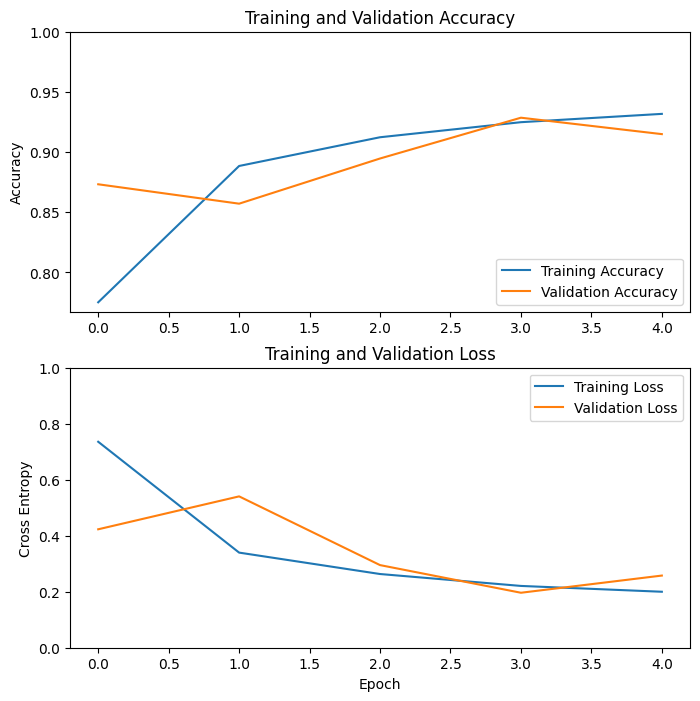

In [12]:
train_accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))

# Plot Training & Validation Accuracy
plt.subplot(2, 1, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Plot Training & Validation Loss
plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


### Accuracy of model on testing data

In [13]:
#loading the model
model=models.load_model("/kaggle/working/best_vgg16_plant_disease_model.keras")

In [14]:
# creating a pandas dataframe of class inices of training data
class_dict = train_generator.class_indices

df = pd.DataFrame(
    list(class_dict.items()),
    columns=['class_name', 'class_index']
)

def preprocessing(s):
    # Split on underscores
    parts = s.split('_') 
    parts = [p for p in parts if p]  
    if not parts:
        return s
    result = parts[0]
    for p in parts[1:]:
        if p:
            result += p[0].upper() + p[1:]
    return result
df['class_name'] = df['class_name'].apply(preprocessing)
print(df)


                                    class_name  class_index
0                               AppleAppleScab            0
1                                AppleBlackRot            1
2                          AppleCedarAppleRust            2
3                                 AppleHealthy            3
4                             BlueberryHealthy            4
5           Cherry(includingSour)PowderyMildew            5
6                 Cherry(includingSour)Healthy            6
7   Corn(maize)CercosporaLeafSpot GrayLeafSpot            7
8                        Corn(maize)CommonRust            8
9                Corn(maize)NorthernLeafBlight            9
10                          Corn(maize)Healthy           10
11                               GrapeBlackRot           11
12                     GrapeEsca(BlackMeasles)           12
13         GrapeLeafBlight(IsariopsisLeafSpot)           13
14                                GrapeHealthy           14
15         OrangeHaunglongbing(CitrusGre

In [15]:
# changing names of some of the class_name
df['class_name'] = df['class_name'].replace({
    'AppleCedarAppleRust': 'AppleCedarRust',
    'AppleAppleScab': 'AppleScab',
    'Corn(maize)CommonRust': 'CornCommonRust',
    'TomatoTomatoYellowLeafCurlVirus': 'TomatoYellowCurlVirus'
})


In [16]:
df

,class_name,class_index
0,AppleScab,0
1,AppleBlackRot,1
2,AppleCedarRust,2
3,AppleHealthy,3
4,BlueberryHealthy,4
5,Cherry(includingSour)PowderyMildew,5
6,Cherry(includingSour)Healthy,6
7,Corn(maize)CercosporaLeafSpot GrayLeafSpot,7
8,CornCommonRust,8
9,Corn(maize)NorthernLeafBlight,9


In [19]:
# accuracy on test images
test_dir = "../input/test/test"
test_filenames = sorted([
    f for f in os.listdir(test_dir)
    if f.lower().endswith((".jpg", ".png"))
])

correct = 0
total = len(test_filenames)

for fname in test_filenames:
    name_no_ext = os.path.splitext(fname)[0]  
    label_str = re.sub(r"\d+", "", name_no_ext) 
    label_str = label_str.replace("_", "")  
    row_matches = df[df['class_name'] == label_str]    
    if len(row_matches) == 1:
        true_class_index = int(row_matches['class_index'].iloc[0])
    else:
        print(f"WARNING: Could not uniquely match label for file: {label_str}")
        total -= 1 
        continue
    path = os.path.join(test_dir, fname)
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0
    image_batch = np.expand_dims(image, axis=0)  
    
    #Get model prediction
    preds = model.predict(image_batch, verbose=0) 
    pred_class_index = np.argmax(preds[0])
    
    if pred_class_index == true_class_index:
        correct += 1
        
accuracy = correct / total if total > 0 else 0
print(f"Accuracy on test images data: {accuracy*100:.2f}%")


Accuracy on test images data: 78.79%
